In [24]:
import numpy as np, pandas as pd, math
import matplotlib.pyplot as plt

class Tp(object):
    
    def __init__(self):
        self.decisionNode = dict(boxstyle='sawtooth', fc='10')
        self.leafNode = dict(boxstyle='round4',fc='0.8')
        self.arrow_args = dict(arrowstyle='<|-')

    def plotNode(self, nodeTxt, centerPt, parentPt, nodeType):
        createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',\
                                 xytext=centerPt,textcoords='axes fraction',\
                                 va='center', ha='center',bbox=nodeType,arrowprops\
                                 =self.arrow_args)

    def getNumLeafs(self, myTree):
        numLeafs = 0
        firstStr = list(myTree.keys())[0]
        secondDict = myTree[firstStr]
        for key in secondDict:
            if(type(secondDict[key]).__name__ == 'dict'):
                numLeafs += getNumLeafs(secondDict[key])
            else:
                numLeafs += 1
        return numLeafs

    def getTreeDepth(self, myTree):
        maxDepth = 0
        firstStr = list(myTree.keys())[0]
        secondDict = myTree[firstStr]
        for key in secondDict:
            if(type(secondDict[key]).__name__ == 'dict'):
                thisDepth = 1 + getTreeDepth((secondDict[key]))
            else:
                thisDepth = 1
            if thisDepth > maxDepth: maxDepth = thisDepth
        return maxDepth

    def retrieveTree(self, i):
        #预先设置树的信息
        listOfTree = [{'no surfacing':{0:'no', 1:{'flipper':{0:'no', 1:'yes'}}}},
                      {'no surfacing':{0:'no', 1:{'flipper':{0:{'head':{0:'no', 1:'yes'}},1:'no'}}}},
                      {'a1':{0:'b1', 1:{'b2':{0:{'c1':{0:'d1',1:'d2'}}, 1:'c2'}}, 2:'b3'}}]
        return listOfTree[i]

    def createPlot(self, inTree):
        fig = plt.figure(1,facecolor='white')
        fig.clf()
        axprops = dict(xticks = [], yticks=[])
        createPlot.ax1 = plt.subplot(111,frameon = False,**axprops)
        plotTree.totalW = float(getNumLeafs(inTree))
        plotTree.totalD = float(getTreeDepth(inTree))
        plotTree.xOff = -0.5 / plotTree.totalW;plotTree.yOff = 1.0
        plotTree(inTree,(0.5,1.0), '')
        plt.show()

    def plotMidText(self, cntrPt, parentPt,txtString):
        xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
        yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
        createPlot.ax1.text(xMid, yMid, txtString)

    def plotTree(self, myTree, parentPt, nodeTxt):
        numLeafs = getNumLeafs(myTree)
        depth = getTreeDepth(myTree)
        firstStr = list(myTree.keys())[0]
        cntrPt = (plotTree.xOff+(1.0+float(numLeafs))/2.0/plotTree.totalW,\
                  plotTree.yOff)
        plotMidText(cntrPt,parentPt,nodeTxt)
        plotNode(firstStr,cntrPt,parentPt,self.decisionNode)
        secondDict = myTree[firstStr]
        plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
        for key in secondDict:
            if type(secondDict[key]).__name__ == 'dict':
                plotTree(secondDict[key],cntrPt,str(key))
            else:
                plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
                plotNode(secondDict[key],(plotTree.xOff,plotTree.yOff),\
                         cntrPt,self.leafNode)
                plotMidText((plotTree.xOff,plotTree.yOff),cntrPt,str(key))
        plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

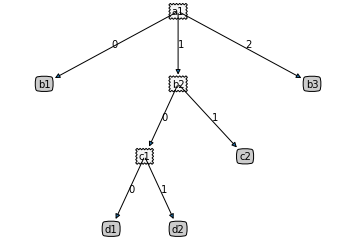

In [28]:
tp = Tp()
myTree = tp.retrieveTree(2)
tp.createPlot(myTree)

## 4.3

In [50]:
data3 = pd.read_csv('./data3_full.csv')
print (data3.columns)
data3['好瓜'] = data3['好瓜'].apply(lambda x: 1 if x == '是' else 0)
data3 = data3.drop(axis=1,columns=['编号'])

Index(['编号', '色泽', '根蒂', '敲声', '纹理', '脐部', '触感', '密度', '含糖率', '好瓜'], dtype='object')


In [ ]:
class TreeNode(object):
    def __init__(self, idx, feature, data, par):
        self.idx = idx
        self.feature = feature
        self.ch = {}
        self.n_ch = 0
        self.data = data
        self.n = len(data)
    def add_son(self, data, idx, feature):
        ch[idx] = TreeNode(idx, feature, data, self.idx)
        self.n_ch += 1
        
class DecisionTree(object):
    
    def __init__(self, data):
        self.data = data
        self.tot = 0
        self.n = len(data)
        self.nodes = {}
    
    def add_node(self, feature, data, par):
        node = TreeNode(tot, feature, data, par)
        if par != -1:
            add_son(par. tot)
        tot += 1
        
    def sel_feature(self):
        pass
    
    def dfs(self):
        (feature_name, feature_val) = sel_feature()
        data_cur = self.data[self.data[feature_name] == feature_val]
        